In [1]:
import torch
import torch.nn
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from model import FCL_Model

from utils import load_dataset
from utils import split_data
from utils import get_hidden_sizes

In [2]:
model_fn = "./test.pth"

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
def load(fn, device):
    d = torch.load(fn, map_location=device)
    
    return d['model'], d['config']

def adjusted_r2(yhat, y):
    SS_Residual = sum((y-yhat)**2)
    SS_Total = sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-x.shape[1]-1)
    return adjusted_r_squared

def plot_balnd_altman(y_hat, y):
    
    f, ax = plt.subplots(1, figsize = (10, 10))
    sm.graphics.mean_diff_plot(y_hat, y, ax = ax)
    plt.show()
    
    return None

def plot_asym(y_hat, y):

    plt.figure(figsize=(10, 10))
    plt.scatter(y=y_hat, x=y)
    plt.xlim(20, 45)
    plt.ylim(20, 45)
    plt.show()

    return None

def plot_qq(y_hat, y):
    res = y - y_hat

    f, ax = plt.subplots(1, figsize=(10,10))
    fig = sm.qqplot(res, ax = ax)
    plt.show()


    

In [5]:
def test(model, x, y, to_be_shown=True):
    model.eval()
    
    with torch.no_grad():
        y_hat = model(x).to(torch.device('cpu')).numpy().reshape(-1, 1)
        y = y.to(torch.device('cpu')).numpy().reshape(-1, 1)

        print("Adjusted R^2: {}".format(adjusted_r2(yhat=y_hat, y=y)))
        print("Multiple Correlation: {}".format(np.power(adjusted_r2(yhat=y_hat, y=y), 1/2)))
        print("SEE: {}".format(np.std(y_hat - y)))
        print("MSE: {}".format(mean_squared_error(y_hat, y)))
        
        if to_be_shown:
            plot_balnd_altman(y_hat=y_hat, y=y)
            plot_asym(y_hat=y_hat, y=y)

            #### QQ-plot isn't good metrics for nonlinear based model
            #plot_qq(y_hat=y_hat, y=y)
    
    return y_hat, y

Adjusted R^2: [0.2791673]
Multiple Correlation: [0.5283629]
SEE: 3.4971182346343994
MSE: 12.229959487915039


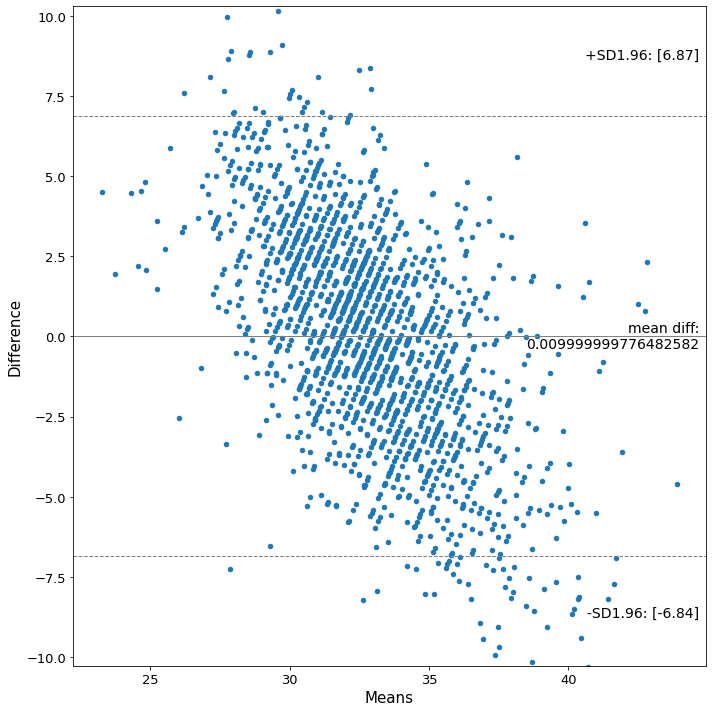

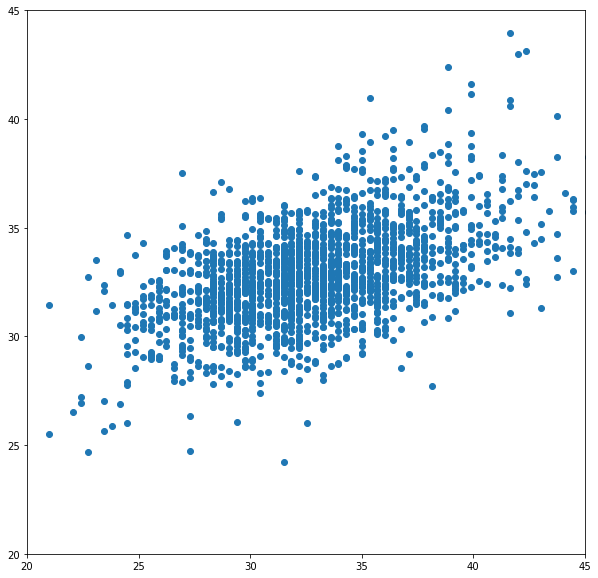

In [6]:
# Load MNIST test set.
x, y = load_dataset()
x, y = split_data(x, y, train_ratio=0.8, device=device)
# Reshape tensor to chunk of 1-d vectors.
x = x[1]
y = y[1]

input_size = int(x.shape[-1])
output_size = 1

model_dict, train_config = load(model_fn, device)

model = FCL_Model(
    input_size=input_size,
    output_size=output_size,
    hidden_sizes=get_hidden_sizes(input_size, output_size,
                                      train_config.n_layers,
                                      train_config.n_node_first_hidden),
    use_batch_norm=not train_config.use_dropout,
    dropout_p=train_config.dropout_p,
).to(device)

model.load_state_dict(model_dict)

y_hat, y = test(model, x, y, to_be_shown=True)

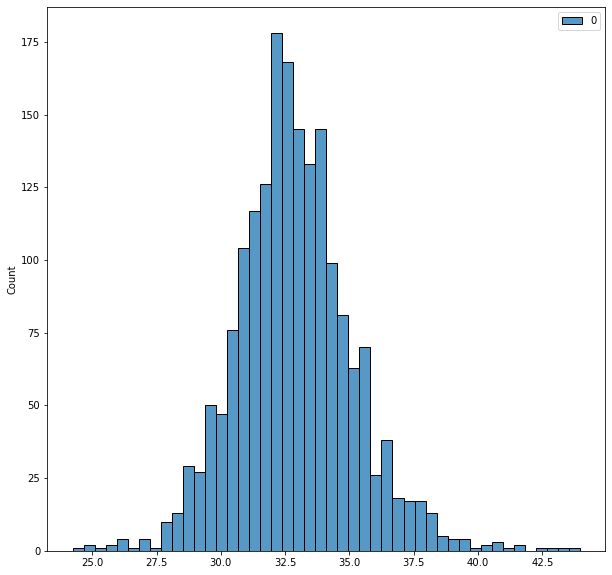

In [7]:
plt.figure(figsize=(10, 10))
sns.histplot(y_hat)
plt.show()